<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/Assignment6/Homework6_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import datetime

#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
data_path = '/content/drive/My Drive/DataSets/'
cifar10 = datasets.CIFAR10(data_path,train=True,download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform = transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [77]:
len(cifar10)

50000

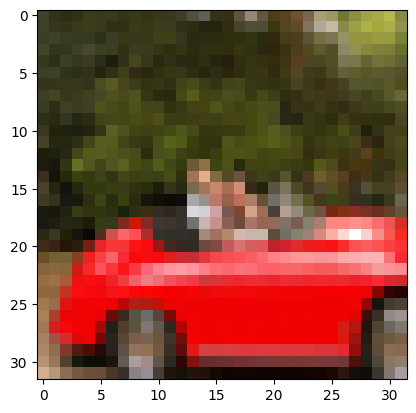

In [78]:
img_t, _ = cifar10[99]
img_t.shape
plt.imshow(img_t.permute(1,2,0))

In [79]:
imgs = torch.stack([img_t for img_t, _ in cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [80]:
imgs.view(3,-1).mean(dim=1)
imgs.view(3,-1).std(dim=1)


tensor([0.2470, 0.2435, 0.2616])

In [81]:
transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [82]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False,download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))]))

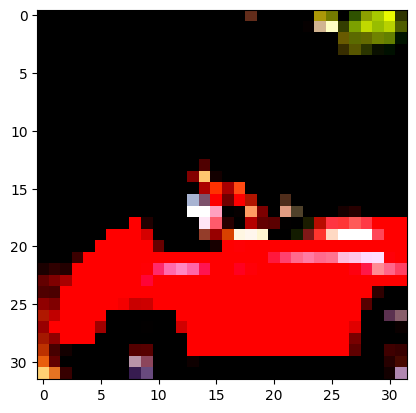

In [83]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [84]:
model = nn.Sequential(nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 10), nn.LogSoftmax(dim=1))



In [85]:
loss = nn.NLLLoss()
img, label = transformed_cifar10[99]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(2.2885, grad_fn=<NllLossBackward0>)

In [86]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size = 64, shuffle=True)

loss_fn = nn.NLLLoss()
n_epochs = 100
losses = []
start = datetime.datetime.now()
for epoch in range(n_epochs):
  for imgs, labels in train_loader:
    batch_size = imgs.shape[0]
    outputs = model(imgs.view(batch_size, -1))
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
  losses.append(loss.item())

end = datetime.datetime.now()

Epoch: 0, Loss: 1.559895
Epoch: 1, Loss: 1.648515
Epoch: 2, Loss: 1.553832
Epoch: 3, Loss: 1.820570
Epoch: 4, Loss: 1.578152
Epoch: 5, Loss: 1.991232
Epoch: 6, Loss: 1.557558
Epoch: 7, Loss: 1.371971
Epoch: 8, Loss: 1.377561
Epoch: 9, Loss: 1.498050
Epoch: 10, Loss: 1.413352
Epoch: 11, Loss: 0.833933
Epoch: 12, Loss: 1.311888
Epoch: 13, Loss: 1.049882
Epoch: 14, Loss: 1.123642
Epoch: 15, Loss: 0.879288
Epoch: 16, Loss: 0.839956
Epoch: 17, Loss: 1.682409
Epoch: 18, Loss: 0.711702
Epoch: 19, Loss: 1.377513
Epoch: 20, Loss: 1.303720
Epoch: 21, Loss: 1.379040
Epoch: 22, Loss: 0.875862
Epoch: 23, Loss: 1.173916
Epoch: 24, Loss: 0.639813
Epoch: 25, Loss: 1.165659
Epoch: 26, Loss: 0.619712
Epoch: 27, Loss: 0.911695
Epoch: 28, Loss: 0.568714
Epoch: 29, Loss: 1.154011
Epoch: 30, Loss: 0.793060
Epoch: 31, Loss: 0.820465
Epoch: 32, Loss: 0.735639
Epoch: 33, Loss: 0.868863
Epoch: 34, Loss: 0.337296
Epoch: 35, Loss: 0.483031
Epoch: 36, Loss: 0.642395
Epoch: 37, Loss: 1.035178
Epoch: 38, Loss: 1.034

In [87]:
time = end-start
print('Training time: ', str(time))

Training time:  0:43:52.098732


In [88]:
val_loader = torch.utils.data.DataLoader(transformed_cifar10_val, batch_size=64,
  shuffle=False)
correct = 0
total = 0
val_losses = []
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        val_losses.append(loss.item())
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy Validation: ", correct / total)

#Training set accuracy
train_loader = torch.utils.data.DataLoader(transformed_cifar10, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy training: " , (correct / total))



Accuracy Validation:  0.4683
Accuracy training:  0.9995


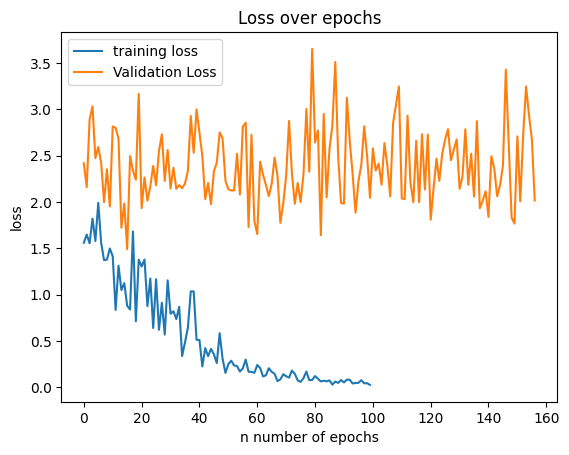

In [90]:
# 4. Plot the training and validation loss after each iteration
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()